# Step 4: Fit Barnacle model to your data

Use this notebook to fit the Barnacle model to your normalized data tensor. Fitting Barnacle to data requires tuning two model parameters: 
1. `R` -- the number of components
1. `lambda` -- the sparsity parameter

There are many methods for fitting model parameters. The cross-validated parameter search strategy here is the method used to fit Barnacle to metatranscriptomic data in the [original Barnacle manuscript](https://doi.org/10.1101/2024.07.15.603627). This strategy aims to reduce resource costs by fitting `R` first and then `lambda`, rather than both parameters simultaneously. It also depends on sample replicates for performing cross validation. If your data does not have sample replicates, you might instead consider trying split-half analysis for parameter selection, but this method is not supported by this notebook.

Please refer to the notebook [3-tensorize-data.ipynb](https://github.com/blasks/barnacle-boilerplate/blob/main/3-tensorize-data.ipynb) for proper formatting of your input data tensor. Note that in order to facilitate bootstrapping, sample ID and replicate ID are combined into a unique identifier called `'sample_replicate_id'` (how creative). This will be the name of the third mode of your tensor. The sample ID and replicate ID information is preserved in separate metadata arrays in the dataset. The script will use this information to shuffle replicates between bootstraps, which enables more robust parameter selection, and confidence intervals in the final model.

In [1]:
# imports

import os
import pandas as pd
import seaborn as sns
import toml
import warnings
import xarray as xr

from matplotlib import pyplot as plt

# suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# set color palette
sns.set_palette(sns.color_palette([
    '#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7'
]))


In [2]:
# USER INPUTS -- edit these variables as needed

# filepath of your input data tensor (e.g. 'directory/example-tensor.nc')
datapath = 'data/data-tensor.nc'

# output directory where produced files will be saved (e.g. 'data/'
outdir = 'data'


In [3]:
# check inputs

# read in data tensor
ds = xr.load_dataset(datapath)

# check input data formats
required_vars = ['data', 'sample_id', 'replicate_id', 'sample_replicate_id']
for var in required_vars:
    if var not in list(ds.variables):
        raise Exception(f"Tensor missing variable '{var}'. See `3-tensorize-data.ipynb` for proper formatting of input tensor dataset.")
if input(f'Found tensor with the following modes and dimensions:\n{dict(ds.sizes)}\nIs this correct? (Y/N):').strip().lower() == 'n':
    raise Exception(f'Please double check input tensor dataset.')
else:
    modes = list(ds.data.coords)

# check if output directory exists
if not os.path.isdir(outdir):
    if input(f"Unable to find output directory '{outdir}'. Would you like to make a new directory? (Y/N):").strip().lower() == 'y':
        os.makedirs(outdir)
    else: 
        raise Exception(f"Unable to find output directory '{outdir}'")

# check sparsity modes
sparse_modes = int(input(f'How many modes will sparsity be applied to? (Enter 0/1/2/3, default is 1)'))
if sparse_modes == 1:
    if input(f'Sparsity will be applied to mode 1-{modes[0]}\nIs this correct? (Y/N):').strip().lower() == 'n':
        raise Exception('Sparsity constraint should be applied to the first mode in the tensor. Please rearrange input tensor.')
elif sparse_modes == 2:
    if input(f'Sparsity will be applied to modes 1-{modes[0]} and 2-{modes[1]}\nIs this correct? (Y/N):').strip().lower() == 'n':
        raise Exception('Sparsity constraints should be applied to first and second modes in the tensor. Please rearrange input tensor.')

ds

Found tensor with the following modes and dimensions:
{'KOfam': 20069, 'phylum': 99, 'sample_replicate_id': 31}
Is this correct? (Y/N): y
How many modes will sparsity be applied to? (Enter 0/1/2/3, default is 1) 1
Sparsity will be applied to mode 1-KOfam
Is this correct? (Y/N): y


<xarray.Dataset> Size: 493MB
Dimensions:              (KOfam: 20069, phylum: 99, sample_replicate_id: 31)
Coordinates:
  * KOfam                (KOfam) <U6 482kB 'K00001' 'K00002' ... 'K26182'
  * phylum               (phylum) <U30 12kB 'Acidobacteriota' ... 'Xanthophyc...
  * sample_replicate_id  (sample_replicate_id) <U17 2kB 'G3.UW.ALL.L25S1_A' ....
Data variables:
    data                 (KOfam, phylum, sample_replicate_id) float64 493MB 0...
    sample_id            (sample_replicate_id) <U15 2kB 'G3.UW.ALL.L25S1' ......
    replicate_id         (sample_replicate_id) <U1 124B 'A' 'B' 'C' ... 'B' 'C'

### Part A: Identifying optimal rank

In this step you will identify the optimal rank for your model. The rank dictates the number of components in the model. If you will be using Barnacle for cluster analysis, the rank directly corresponds to the number of clusters output by the model.

The optimal value of rank can be identified via cross-validation. You will fit a series of models with different rank values, and then compare how well these models reproduce held out replicates from your dataset. To isolate the rank parameter from the sparsity parameter, this first cross-validated parameter search is done without applying any sparsity to the model.

Identifying the optimal rank requires the following steps:
1. Enter a list of rank values you would like to assess. A good starting range might be 1 - 30 in intervals of 5.
1. Run the `grid-search.py` script using the config file generated by this notebook (`rank-search.toml`).
    - You should run this script from the command line, outside of this notebook.
    - This step can last anywhere from minutes to days, or more, depending on the size of your data, the rank values you are testing, and the specs of your computer system. If it is taking a long time to run, consider testing a smaller set of rank values, running fewer bootstraps, running on a more powerful computer, or distilling your data down to a subset you are most interested in analyzing.
1. Look for a minimum in the cross-validated sum of squared errors (SSE).
    - If you do not see a minimum, you may need to repeat these steps, testing a broader range of rank values.


In [4]:
# USER INPUTS -- edit these variables as needed

# list values of R (rank) to test
ranks = [1, 5, 10, 15, 20, 25, 30]

# list which modes of the tensor model should be constrained to be non-negative (modes are 0-indexed)
nonneg_modes = [1, 2] # default is [1, 2] (i.e. first mode unconstrained, other two modes must be nonnegative values)

# enter random seed (integer)
seed = 9481


In [5]:
# build config file

# config file structure
config = {
    "grid": {
        "ranks": ranks,
        "lambdas": [[0., 0., 0.]]
    },
    "params": {
        "nonneg_modes": nonneg_modes,
        "tol": 0.00001, 
        "n_iter_max": 2000,
        "n_initializations": 5
    },
    "script": {
        "input": datapath,
        "outdir": f"{outdir}/fitting",
        "n_bootstraps": 10,
        "replicates": [str(l) for l in set(ds.replicate_id.data)],
        "max_processes": os.cpu_count(),
        "seed": seed
    }
}

# function to save config as toml file
def save_toml(config, filename="config.toml"):
    with open(filename, "w") as f:
        toml.dump(config, f)
    print(f"TOML file '{filename}' created successfully.")

# save and display config toml file
save_toml(config, filename=f"{outdir}/rank-search.toml")
print(f"\n{toml.dumps(config)}")

# print command to initiate rank search
print(
    f"""Run the following command from the command line:

    poetry run python grid-search.py {outdir}/rank-search.toml
    """
)


TOML file 'data/rank-search.toml' created successfully.

[grid]
ranks = [ 1, 5, 10, 15, 20, 25, 30,]
lambdas = [ [ 0.0, 0.0, 0.0,],]

[params]
nonneg_modes = [ 1, 2,]
tol = 1e-5
n_iter_max = 2000
n_initializations = 5

[script]
input = "data/data-tensor.nc"
outdir = "data/fitting"
n_bootstraps = 10
replicates = [ "A", "B", "C",]
max_processes = 16
seed = 9481

Run the following command from the command line:

    poetry run python grid-search.py data/rank-search.toml
    


#### Initialize cross-valiated rank search

Run the above command from your computer's command line. This step may take anywhere from minutes to days to complete. Once it has successfully completed, it should have produced a number of directories and files within your output directory, including the following csv file that contains the cross-validated SSE data:

`fitting/cv_data.csv`

You can then run the following code to look for a minimum in the cross-validated SSE data. 

The minimum average cross-validated SSE was 0.954, acheived with R=5.
Please re-run the cross-validated rank search to include higher values of rank.


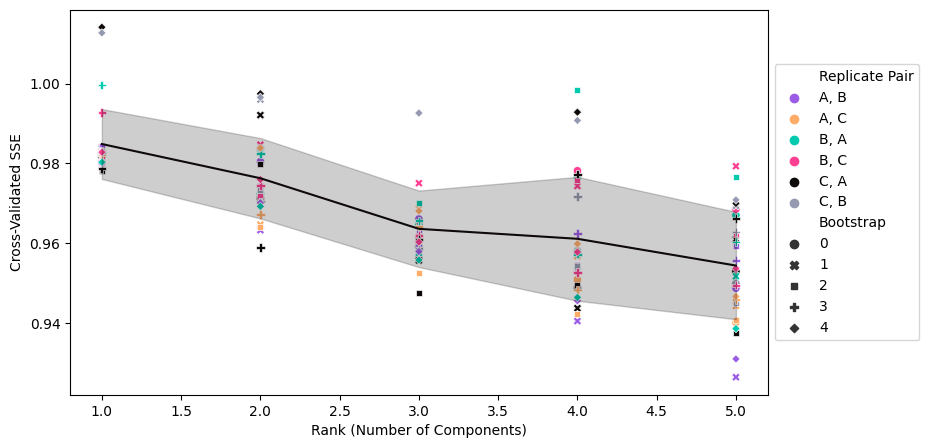

In [39]:
# visualize the result of the cross validation run

# read in cross-validation data
cv_df = pd.read_csv(f"{outdir}/fitting/cv_data.csv")
# down-select to just true cross-validation data
cv_df = cv_df[cv_df['modeled_replicate'] != cv_df['comparison_replicate']].reset_index(drop=True)
cv_df['Replicate Pair'] = cv_df['modeled_replicate'] + ', ' + cv_df['comparison_replicate']
cv_df['Bootstrap'] = cv_df.bootstrap_id.astype(str)

# calculate minimum average cross-validated SSE
avg_cv_sse = cv_df.groupby('rank').sse.mean()
rank_min_sse = int(avg_cv_sse.idxmin())
print(f'The minimum average cross-validated SSE was {avg_cv_sse.min():.3}, acheived with R={rank_min_sse}.')
if rank_min_sse == cv_df['rank'].min():
    if rank_min_sse == 1:
        print('This may indicate a high level of noise in your data. You may need to reconsider preprocessing and normalization.')
    else:
        print('Please re-run the cross-validated rank search to include lower values of rank.')
elif rank_min_sse == cv_df['rank'].max():
    print('Please re-run the cross-validated rank search to include higher values of rank.')
else:
    print(f'This indicates an optimal rank value of {optimal_rank}. Proceed to select the optimal value of lambda.')

# plot cross-validated SSE as a function of rank
fig, axis = plt.subplots(figsize=(9,5))
sns.scatterplot(data=cv_df, x='rank', y='sse', hue='Replicate Pair', style='Bootstrap', ax=axis, legend=True)
sns.lineplot(data=cv_df, x='rank', y='sse', color=sns.color_palette()[4], errorbar='sd', ax=axis)
axis.legend(loc='center left', bbox_to_anchor=(1,0.5));
axis.set(xlabel='Rank (Number of Components)', ylabel='Cross-Validated SSE'); 


### Part B: Identifying optimal sparsity

In this step you will identify the optimal sparsity for your model. Sparsity can be applied to 0, 1, 2, or all three modes of your model. The default is to apply sparsity just to the first mode, which should correspond to the variable you want to cluster (e.g. genes in the case of metatranscriptomic data). It is important that the modes with sparsity constraints are the first ones listed, so please re-orient your input data tensor if that is not the case.

The optimal sparsity parameter (lambda) will be identified with another cross-validated parameter search. You will fit a series of models with different lambda values, and then compare how well these models reproduce held out replicates from your dataset. All models in this search will be fit with rank set to the optimal value identified in Part A.

Identifying the optimal lambda requires the following steps:
1. Enter a list of lambda values you would like to assess.
    - Powers of 2 or 10 are a good idea for an initial coarse search.
    - A linear search is a good idea to fine-tune the optimal value of lambda.
1. Run the `grid-search.py` script using the config file generated by this notebook (`lambda-search.toml`).
    - You should run this script from the command line, outside of this notebook.
    - This step can last anywhere from minutes to days, or more, depending on the size of your data, the lambda values you are testing, and the specs of your computer system. However it is often faster than the rank search since sparse models are faster to fit.
1. Look for an optimum in the cross-validated data. There is no single best rule for this selection, but two rules of thumb are offered below.

In [37]:
# USER INPUTS -- edit these variables as needed

# list values of lambda (sparsity penalty) to test
# lambdas = [0., 0.01, 0.1, 1., 10.] # powers of ten (coarse search)
# lambdas = [0., 0.2, 0.4, 0.6, 0.8, 1., 1.2, 1.4, 1.6, 1.8, 2.] # linear (fine-tuned search)
lambdas = [0., 0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8] # powers of two (one-shot search)

# list wich modes of the tensor model should have sparsity applied to them (modes are 0-indexed)
sparsity_modes = [0] # default is [0] (i.e. sparsity applied to first mode only)

# enter optimal rank (identified in part A)
optimal_rank = rank_min_sse

# enter random seed (integer)
seed = 42


In [38]:
# build config file

# update ranks and lambdas
config['grid']['ranks'] = [optimal_rank]
config['grid']['lambdas'] = [[float(l) if i in sparsity_modes else 0.0 for i in [0, 1, 2]] for l in lambdas]

# update random seed
config['script']['seed'] = seed

# save and display config toml file
save_toml(config, filename=f"{outdir}/lambda-search.toml")
print(f"\n{toml.dumps(config)}")

# print command to initiate sparsity parameter search
print(
    f"""Run the following command from the command line:

    poetry run python grid-search.py {outdir}/lambda-search.toml
    """
)


TOML file 'data/lambda-search.toml' created successfully.

[grid]
ranks = [ 5,]
lambdas = [ [ 0.0, 0.0, 0.0,], [ 0.001, 0.0, 0.0,], [ 0.01, 0.0, 0.0,], [ 0.1, 0.0, 0.0,], [ 1.0, 0.0, 0.0,], [ 10.0, 0.0, 0.0,],]

[params]
nonneg_modes = [ 1, 2,]
tol = 1e-5
n_iter_max = 2000
n_initializations = 5

[script]
input = "data/data-tensor.nc"
outdir = "data/fitting"
n_bootstraps = 10
replicates = [ "A", "B", "C",]
max_processes = 16
seed = 42

Run the following command from the command line:

    poetry run python grid-search.py data/lambda-search.toml
    


#### Initialize cross-valiated sparsity parameter search

Run the above command from your computer's command line. This step may take anywhere from minutes to days to complete. Once it has successfully completed, it should have produced a number of directories and files within your output directory, and should have updated the `fitting/cv_data.csv` to included cross-validated data from models with the different sparsity parameters tested. These data include:
- Sum of Squared Errors (SSE): Measures how well a model fit to one subset of your data reproduces another subset of your data held out during fitting
- Factor Match Score (FMS): Measures the similarity components between models fit to different subsets of your data

You can then run the following code to help identify the optimal lambda based on the cross-validation data. There is no single best rule for this selection, but here are two rules of thumb you could consider:
- Minimum SSE: As when selecting rank, select the lambda that corresponds to the lowest average cross-validated SSE. This heuristic tends to lead to the most conservative choice of lambda.
- Maximum FMS: FMS measures the similarity of components between models fit to different subsets of your data. When you're interested in clusters this FMS can be thought to measure the robustness and reproducibility of clusters. This heuristic tends to lead to higher values of lambda than SSE and thus sparser models.

Additionally, to account for variation in the bootstraps, you can use the "one standard error rule" (see e.g. Hastie, Tibshirani and Friedman, 2009) in combination with either the min SSE or max FMS heuristic. This convention suggests that instead of taking the true optimum (min SSE or max FMS), we take the highest value of lambda that lays within one standard error of the optimum. The second block of code calculates optimal values of lambda based on this heuristic.

In [ ]:
# import data


# calculate min SSE

summary_df = summary_df.groupby(['genus', 'rank', 'lambda'])[['mean_gene_sparsity', 'relative_sse', 'fms_cv']].agg(
    mean_gene_sparsity=('mean_gene_sparsity', 'mean'), 
    relative_sse=('relative_sse', 'mean'), 
    fms_cv=('fms_cv', 'mean'), 
    fms_sem=('fms_cv', 'sem'), 
    bootstraps=('fms_cv', 'count')
).reset_index()

# calculate sparsest Pro clusters within one SE of the max CV FMS (one-SE rule)

# pro max FMS
pro_best_fms = summary_df.loc[summary_df[summary_df['genus'] == 'pro'].fms_cv.idxmax(), :]
print('max CV FMS: \n\n{}\n'.format(pro_best_fms))
pro_1se_fms = pro_best_fms['fms_cv'] - pro_best_fms['fms_sem']
print('max CV FMS - 1SE: {}\n'.format(pro_1se_fms))

# show all models with at least the minimum FMS, sorted from sparsest to least sparse
summary_df[(summary_df['genus'] == 'pro') & (summary_df.fms_cv.ge(pro_1se_fms))].sort_values('lambda', ascending=False)



# calculate max FMS


# plot SSE and FMS as a function of lambda

